In [19]:
import numpy as np
import sys
sys.path.append("../model")
from rnn_FORCE import RNN
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torch import nn
import seaborn as sns
from torch.autograd.functional import jacobian
SAVEFIG = True

In [2]:
# Initializing matrix
num_nodes = 200
np.random.seed(3)  # 2

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

In [3]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = num_nodes/4
inh_weight_sum = num_nodes/4
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [4]:
# define targets
time_points = np.arange(2000)
half_period = 20
# targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5
targets = ((np.sin((time_points + 10)/half_period*np.pi))/4 + 0.5)

# inputs with different phases and period
np.random.seed(3)
inputs = []
for i in range(num_nodes):
    this_half_period = np.random.randint(10, 30)
    this_input = (np.sin((time_points + np.random.randint(0, half_period*2))/this_half_period*np.pi))/4 + 0.5
    inputs.append(this_input)
inputs = np.array(inputs)

In [5]:
# define sigmoid
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)

Must use activation as x rather than state. Otherwise, the output would not be a linear readout and depend on u.

In [6]:
# imitate rnn_FORCE
class mysys():
    def __init__(self, weight_matrix, connectivity_matrix, gain, shift, input_weight_matrix=None, inputs=None):
        # core parameters
        self.weight_matrix = weight_matrix
        self.connectivity_matrix = connectivity_matrix
        self.gain = gain
        self.shift = shift
        self.inputs = inputs
        self.input_weight_matrix = input_weight_matrix
        self.activation_func = nn.Sigmoid()
        
        # transfer into tensor
        self.weight_matrix_tensor = tensor(self.weight_matrix)
        self.gain_tensor = tensor(self.gain)
        self.shift_tensor = tensor(self.shift)
        
        # constants
        self.time_const = 1
        self.timestep = 0.1
        self.c = self.timestep / self.time_const
        self.g = 1.5
        self.i = 0

    def f_tensor(self, x_tensor, u_tensor, r_tensor):
        # this_input_tensor = torch.matmul(tensor(self.input_weight_matrix), tensor([[self.inputs[self.i]]]))
        y_tensor = (1 - self.c) * x_tensor \
            + self.c * self.activation_func((self.gain_tensor + u_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) + r_tensor - self.shift_tensor))
        return y_tensor
     
    def f(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        y_tensor = self.f_tensor(x_tensor, u_tensor, r_tensor)
        y = y_tensor.numpy()
        return y
    
    def jacob(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        dydx, dydu, dydr = jacobian(self.f_tensor,(x_tensor, u_tensor, r_tensor))
        Jx_tensor = dydx.squeeze(dim=(1,3))
        Ju_tensor = dydu.squeeze(dim=(1,3))
        Jr_tensor = dydr.squeeze(dim=(1,3))
        Jx = Jx_tensor.numpy()
        Ju = Ju_tensor.numpy()
        Jr = Jr_tensor.numpy()
        return Jx, Ju, Jr

# jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
# jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)
jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)

### Simulate Without Control

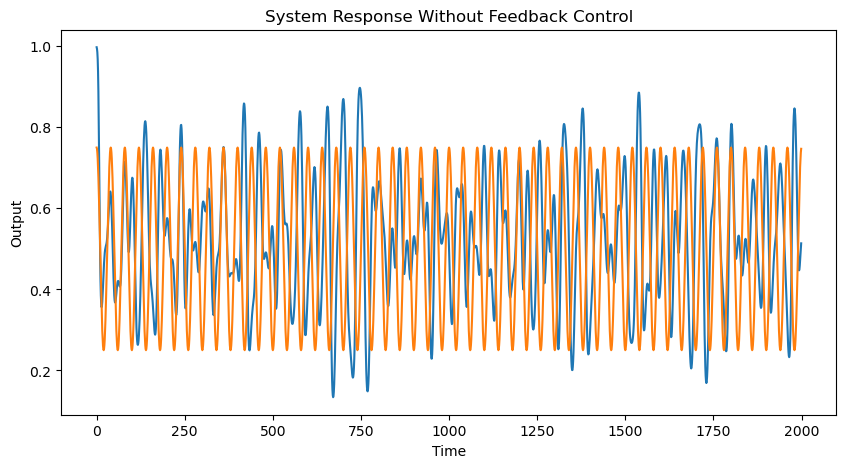

In [7]:
# Simulation Without Control
x = sigmoid_np(init_gain * init_state.copy() - init_shift)
u = init_state.copy() * 0
xs_ff_init, outputs_ff_init = [x], []
gainout= 5.5 # 1.15
shiftout= -5 # -2.5
out_lr = 0.002

for i in time_points[:-1]:
    
    # jnn_ff.i = i

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # # adjust the gainout and shiftout
    # period = 2 * half_period
    # if i > period:
    #     mean_output = np.mean(outputs_ff_init[i-period:i])
    #     amplitude = np.max(outputs_ff_init[i-period:i]) - np.min(outputs_ff_init[i-period:i])
    #     if np.abs(mean_output - 0.5) > 0.01:
    #         shiftout += out_lr * np.sign(mean_output - 0.5)
    #     if np.abs(amplitude - 0.5) > 0.01:
    #         gainout -= out_lr * np.sign(amplitude - 0.5)

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # update x
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()
    
    # save
    xs_ff_init.append(x)
    outputs_ff_init.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_ff_init.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_init)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

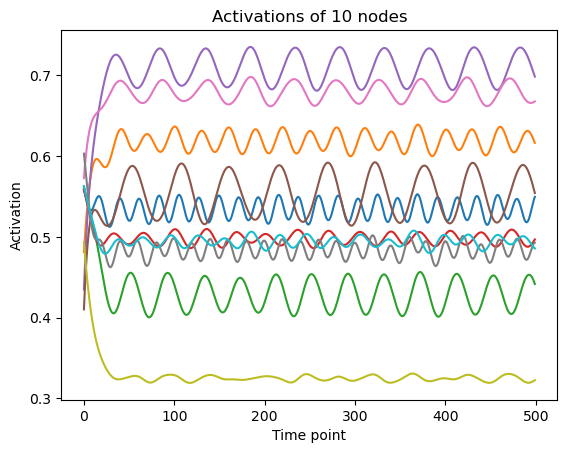

In [8]:
all_xs_ff_init = np.concatenate(xs_ff_init, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_ff_init[i,0:500], label=f"Node {i}")
plt.xlabel("Time point")
plt.ylabel("Activation")
plt.title("Activations of 10 nodes")
if SAVEFIG:
    plt.savefig("fig/FORCE_ff_activations_0424.png")

### Hebbian learning with target

In [16]:
# calculate the desired output before the output sigmoid
gainout= 2.5 # 1.15
shiftout= -1 # -2.5
out_lr = 0.002
y_tildes = inv_sigmoid_np(targets) / gainout  + shiftout

In [17]:
# Simulate with control
x = init_state.copy()
u = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs_hebb, us_hebb, outputs_hebb_beforesig, outputs_hebb = [x], [], [], []
has_hebbian = False
adjust_out = False

# constants
hebbian_lr = 0.01
u_scale = 1

for t in time_points[:-1]:

    # jnn.i = t

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    if not has_hebbian and t > 500:
        has_hebbian = True
        x_mean = np.concatenate(xs_hebb, axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs_hebb, axis=1).std(axis=1).reshape(-1, 1)
        target_mean = 0.5
    
    # # start adjusting the output gains and shifts
    # if t > 2000:
    #     adjust_out = True
    #     has_hebbian = False
    #     period = 2 * half_period
    
    if has_hebbian:
        this_target = targets[t]
        # Calculate Hebbian weight updates
        hebbian_update = (this_target - target_mean) * ((x - x_mean) / x_std).T
        # hebbian_update = (output - output_mean) * ((x - x_mean) / x_std).T
        # hebbian_update = output * x.T
        # hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()
    
    # # adjust the gainout and shiftout
    # if adjust_out:
    #     mean_output = np.mean(outputs_hebb[t-period:t])
    #     amplitude = np.max(outputs_hebb[t-period:t]) - np.min(outputs_hebb[t-period:t])
    #     if np.abs(mean_output - 0.5) > 0.01:
    #         shiftout += out_lr * np.sign(mean_output - 0.5)
    #     if np.abs(amplitude - 0.5) > 0.01:
    #         gainout -= out_lr * np.sign(amplitude - 0.5)

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)
    
    # if adjust_out:
    #     u_scale *= 0.99
    #     u = u_scale * u
    
    # update x
    x1 = jnn.f(x, u, r)
    # x1_0 = F @ x + G @ u + c
    # x1_1 = F_aug @ x_aug + G_aug @ u
    # print(np.linalg.norm(x1_0-x1))
    # print(np.linalg.norm(x1_1[0:num_nodes,:]-x1))
    x = x1.copy()
    
    # save
    xs_hebb.append(x)
    us_hebb.append(u)
    outputs_hebb_beforesig.append(output_beforesig.item())
    outputs_hebb.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_hebb_beforesig.append(output_beforesig.item())
outputs_hebb.append(output.item())

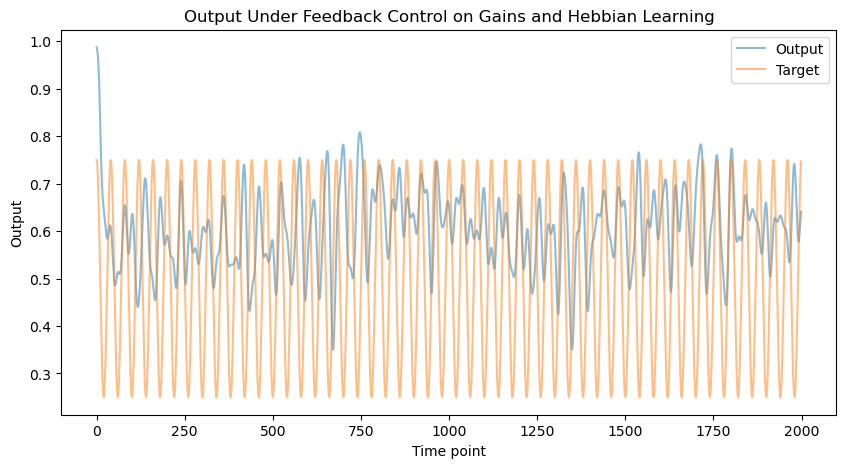

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_hebb, label='Output', alpha=0.5)
plt.plot(time_points, targets, label='Target', alpha=0.5)
plt.title('Output Under Feedback Control on Gains and Hebbian Learning')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_basis_hebb_output_0510.png")

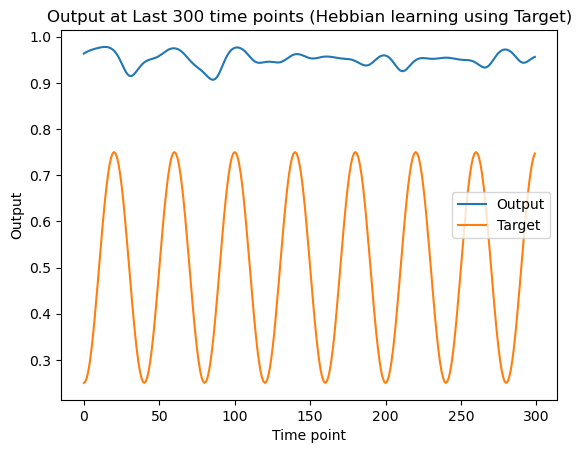

In [12]:
plt.plot(outputs_hebb[-300:], label='Output')
plt.plot(targets[-300:], label='Target')
plt.title('Output at Last 300 time points (Hebbian learning using Target)')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_wavebasis_outputhcp.png")

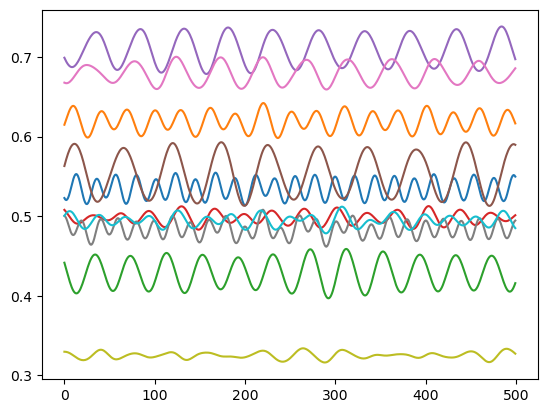

In [13]:
all_xs_hebb = np.concatenate(xs_hebb, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_hebb[i,1500:], label=f"Node {i}")

In [14]:
peaks = []
start = 1600
end = start + 2*half_period
for i in range(num_nodes):
    y = all_xs_hebb[i]
    p = np.argmax(y[start:end])
    peaks.append(p)
target_peak = np.argmax(targets[start:end])
relative_peaks_hebb = np.array(peaks) - target_peak

# plus 120 for relative peaks less than 0
relative_peaks_hebb[relative_peaks_hebb < 0] += 2*half_period
relative_peaks_hebb

array([15, 16, 19,  8, 20, 15, 19, 16, 39,  5, 23, 29, 13, 30, 33, 20, 24,
       20, 18, 25, 15, 39, 39, 10, 19, 23,  0, 23, 18, 21, 39, 12, 24,  0,
       21, 28, 21, 24, 35,  0, 20, 26,  0, 13, 35, 23, 21, 18, 26, 28, 29,
       26, 16, 16, 22,  2, 39, 18,  0, 21, 27, 17, 39, 32, 26, 17, 21, 18,
       17, 12, 21, 33, 19, 28, 10, 16, 36, 21, 35, 21,  6, 32, 29, 39,  0,
       23, 22, 29, 35, 39, 25, 10, 28, 17, 27, 28, 13, 20, 25, 20, 26, 22,
       26, 21, 26, 29, 38, 39, 24,  4, 23, 27, 31, 39,  1, 21, 30, 10, 25,
       21, 19, 31, 27,  0, 17, 15, 23, 31, 38, 11, 28, 30, 14, 23, 37, 16,
       16, 26, 19, 34, 21, 22, 26, 34, 20, 25, 17, 29, 13,  0, 20, 25,  1,
       27, 23, 11, 39, 39, 36, 16, 15, 22, 37, 20, 32,  0, 13, 27, 21, 23,
       24,  7, 33, 18, 22, 24,  4,  9,  5, 25, 20, 19, 17, 27,  0, 18,  0,
       36, 25, 20,  0, 22, 38, 27, 31, 28,  0, 16, 28, 17])

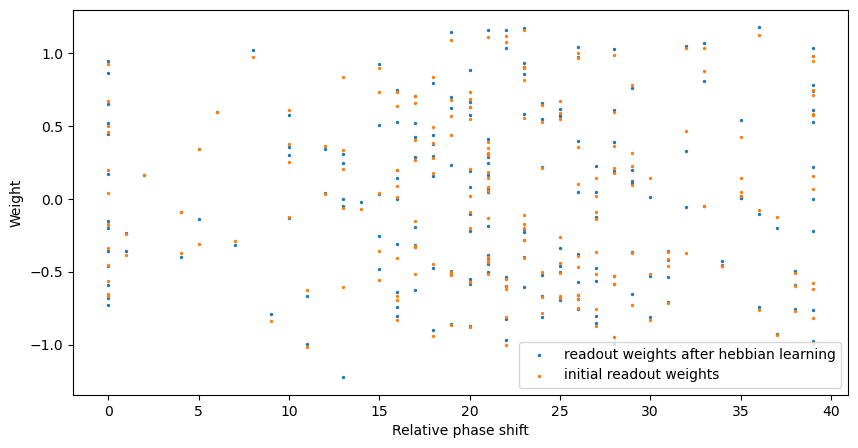

In [15]:
plt.subplots(figsize=(10, 5))
plt.scatter(relative_peaks_hebb, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(relative_peaks_hebb, output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Relative phase shift")
plt.ylabel("Weight")
plt.legend()